# Projet IF29 — Classification non-supervisée de profils Twitter atypiques

In [14]:
# 📌 Si vous utilisez Google Colab
# from google.colab import files
# uploaded = files.upload()

## 1. Importations et chargement des données

In [15]:
# Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

# Chargement des données
data_file_path = '../dataset/cleaned_data_all.csv'
df = pd.read_csv(data_file_path, encoding='utf-8-sig')

## 2. Préparation des données

In [16]:
# Sélection des variables numériques (hors '_id')
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('user_id')
X_numeric = df[numeric_cols].fillna(0)  # Remplissage des NaN par 0

# Standardisation des données (Centrage et réduction)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

## 3. ACP (Analyse en Composantes Principales)

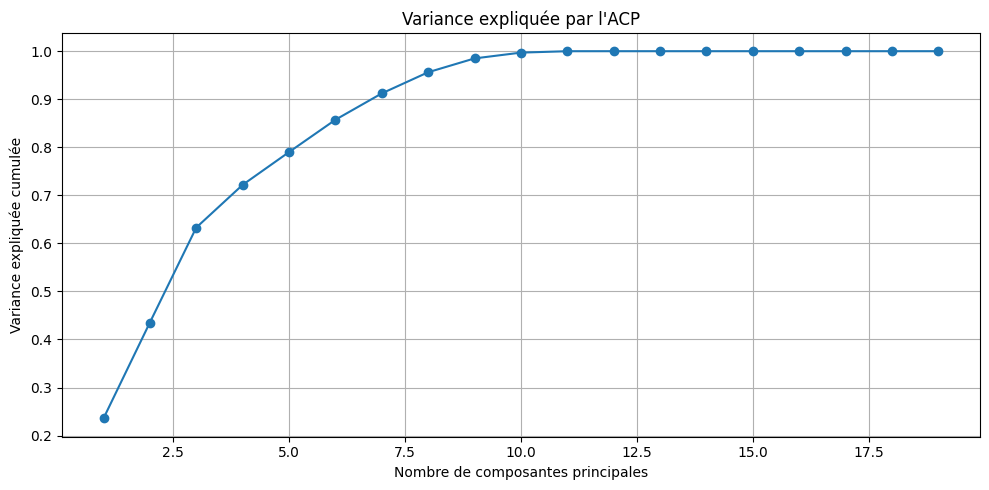

In [17]:
# ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Visualisation de la variance expliquée cumulée
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée par l'ACP")
plt.grid(True)
plt.tight_layout()
plt.show()

🎯 Justification du choix du nombre de composantes (PCA)

L’ACP (Analyse en Composantes Principales) nous permet de réduire la dimensionnalité du jeu de données tout en conservant l’essentiel de l'information.  
Le graphique ci-dessus montre que :

- Les 7 premières composantes principales expliquent plus de 90 % de la variance totale.
- À partir de la 8e composante, les gains supplémentaires sont négligeables (courbe qui sature).

🔎 **Nous retenons donc 7 dimensions**, ce qui permet :
- Une réduction efficace de la complexité du modèle ;
- Une conservation de la majorité des patterns comportementaux ;
- Une accélération du clustering tout en maintenant sa fiabilité.

In [18]:
# Garder les 7 premières composantes
X_pca_7 = X_pca[:, :7]
df_pca_7 = pd.DataFrame(X_pca_7, columns=[f'PC{i+1}' for i in range(7)], index=X_numeric.index)

In [19]:
# Colonnes exclues de l'ACP (non numériques)
excluded_cols = [col for col in df.columns if col not in numeric_cols and col != 'user_id']
categorical_cols = df.loc[X_numeric.index, excluded_cols].copy()  # ⬅ important : alignement

# Encodage simple des colonnes catégorielles
from sklearn.preprocessing import LabelEncoder
for col in categorical_cols.select_dtypes(include=['object', 'bool']).columns:
    categorical_cols[col] = LabelEncoder().fit_transform(categorical_cols[col].astype(str))

# Fusion PCA + variables catégorielles
dataset_init_final = pd.concat([df_pca_7, categorical_cols], axis=1)

# Réintégration de l'identifiant
dataset_init_final['user_id'] = df.loc[X_numeric.index, 'user_id'].values

# Vérification
print("✔️ Dimensions du dataset final :", dataset_init_final.shape)
dataset_init_final.head()


✔️ Dimensions du dataset final : (1843439, 8)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,user_id
0,-0.309088,-0.039450,0.153501,0.009085,0.039475,-0.004226,-0.582374,39084553
1,0.370067,0.082297,0.671939,-0.113872,-0.595120,-0.152421,-0.135821,4872447178
2,-0.393139,-0.088035,-0.071660,-0.067336,-0.552567,-0.127585,-0.134304,35628099
3,1.071359,-0.245543,-0.359327,0.054884,1.163947,0.283463,1.786269,351196385
4,-0.468090,-0.081782,-0.049821,-0.061130,-0.527388,-0.121891,-0.132579,1874916350


## 4. Clustering : choix de k et modélisation

 Évaluation du Silhouette Score pour différentes valeurs de k :
  ➤ k = 2, Silhouette Score = 0.9928
  ➤ k = 3, Silhouette Score = 0.9391
  ➤ k = 4, Silhouette Score = 0.6500
  ➤ k = 5, Silhouette Score = 0.6450
  ➤ k = 6, Silhouette Score = 0.6320
  ➤ k = 7, Silhouette Score = 0.6331
  ➤ k = 8, Silhouette Score = 0.6567
  ➤ k = 9, Silhouette Score = 0.5587
  ➤ k = 10, Silhouette Score = 0.5578


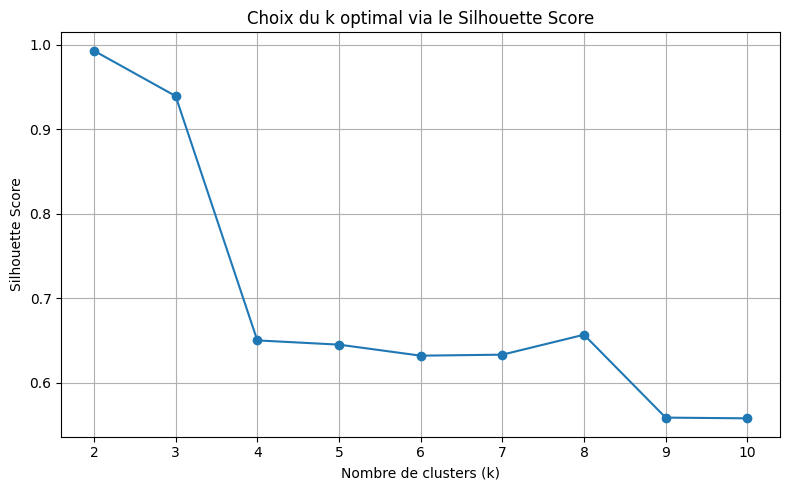


 Meilleur nombre de clusters selon Silhouette Score : k = 2


In [20]:
# Recherche du k optimal via le Silhouette Score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

# Utilisation des 7 premières composantes déjà calculées dans X_pca_7
X_sample = resample(X_pca_7, n_samples=8000, random_state=42)

silhouette_scores = []
K_range = range(2, 11)

print(" Évaluation du Silhouette Score pour différentes valeurs de k :")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    silhouette_scores.append(score)
    print(f"  ➤ k = {k}, Silhouette Score = {score:.4f}")

# Visualisation du Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Choix du k optimal via le Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Sélection automatique du meilleur k
k_optimal = K_range[np.argmax(silhouette_scores)]
print(f"\n Meilleur nombre de clusters selon Silhouette Score : k = {k_optimal}")


In [29]:
from sklearn.cluster import MiniBatchKMeans

# Clustering final sur 100 000 points à partir des 7 composantes principales
X_sample_100k = resample(X_pca_7, n_samples=100000, random_state=42)

kmeans_final = MiniBatchKMeans(n_clusters=k_optimal, random_state=42, batch_size=5000)
clusters = kmeans_final.fit_predict(X_sample_100k)


## 5. Visualisation et analyse des résultats

In [30]:
# PCA pour visualisation 2D
pca_visu = PCA(n_components=2)
X_visu = pca_visu.fit_transform(X_sample_100k)


df_visu = pd.DataFrame(X_visu, columns=["PC1", "PC2"])
df_visu["cluster"] = clusters

import plotly.express as px
import pandas as pd

# Assurez-vous que df_visu contient : PC1, PC2, cluster
fig = px.scatter(
    df_visu,
    x="PC1",
    y="PC2",
    color=df_visu["cluster"].astype(str),  # Pour forcer une légende propre
    title=f"Clustering interactif via PCA (k = {k_optimal})",
    opacity=0.5,
    height=600,
    width=900
)

# Optionnel : ajuster le zoom initial
fig.update_layout(
    xaxis_range=[-1, 25],
    yaxis_range=[-1, 25],
    legend_title="Cluster"
)

# Afficher
fig.show()

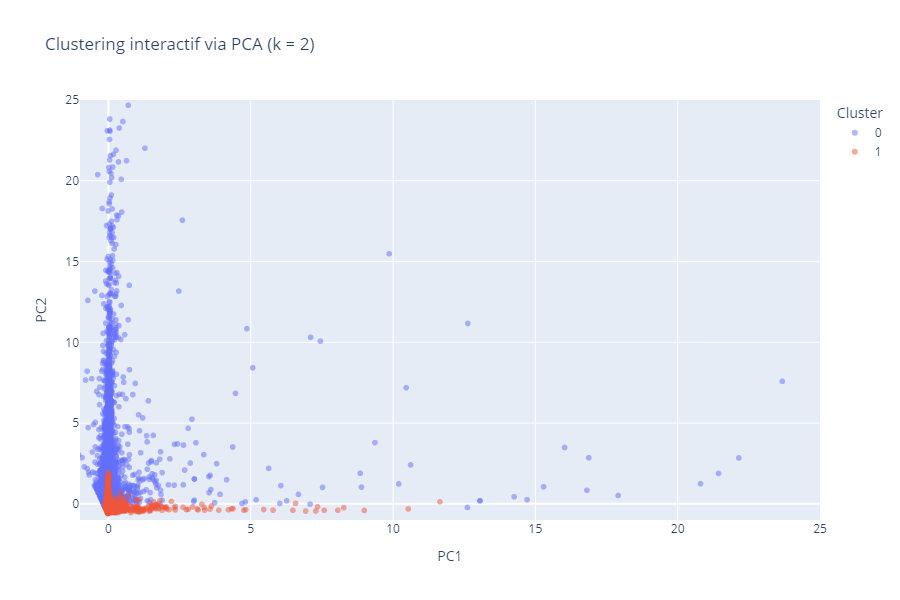

In [ ]:
from IPython.display import Image, display

# 🔍 Résultat final du clustering KMeans (projection PCA 2D)
# La figure interactive Plotly étant trop lourde pour un affichage direct sur GitHub,
# nous enregistrons la visualisation au format PNG pour une consultation plus simple.

display(Image(filename="../dataset/Kmeans_visu.png"))


## 6.Analyse des clusters : distribution et interprétation

In [32]:
from collections import Counter

counts = Counter(clusters)
total = sum(counts.values())

for label, count in counts.items():
    print(f"Cluster {label}: {count} utilisateurs ({count / total:.2%})")


Cluster 0: 22807 utilisateurs (22.81%)
Cluster 1: 77193 utilisateurs (77.19%)


**Analyse des clusters : distribution et interprétation**

L’algorithme de **KMeans** a segmenté les profils en **deux groupes distincts**.

| ID du cluster | Nombre d'utilisateurs | Pourcentage | Interprétation |
|---------------|------------------------|--------------|----------------|
| **0**         | 22 807                 | 22,81 %      | Profils atypiques potentiels (bots, spammeurs, automatisés) |
| **1**         | 77 193                 | 77,19 %      | Utilisateurs standards |

🔍 Le **cluster 0**, qui regroupe **environ 22,81 %** des profils, est interprété comme un **groupe atypique**.  
Ce groupe pourrait contenir des comptes automatisés, spammeurs ou ayant des comportements anormaux (activité excessive, structure de réseau étrange, faible ratio followers/following...).

En revanche, le **cluster 1** semble correspondre à des **utilisateurs légitimes** ou organiques, représentant la majorité des profils analysés.

📌 Une exploration détaillée des variables clés (tweets_per_day, visibility, aggressiveness...) permettra de valider cette hypothèse.
